# Model

In [15]:
import json

# Load the configuration from the JSON file
with open('D:/BrainAge/HCCT/config.json', 'r') as f:
    config = json.load(f)

In [16]:
from model import ViTForClassfication

# Initialize the model with the loaded configuration
model = ViTForClassfication(config=config)

In [7]:
def count_parameters(model, trainable_only=True):
    if trainable_only:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())


In [ ]:
total_params = count_parameters(model, trainable_only=False)
trainable = count_parameters(model, trainable_only=True)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable}")

Total parameters: 4715246
Trainable parameters: 4715246


In [5]:
import torch
extra_features= torch.randn(1,108)
x = torch.randn(16, 1, 91, 109, 91)
# output= model(x, extra_features)
output = model(x, output_attentions=False, return_cam=False)

In [8]:
output[0].item()

-0.16942736506462097

In [9]:
output[0].item()

-0.13305659592151642

In [11]:
a,b,c,d= output

ValueError: not enough values to unpack (expected 4, got 2)

In [16]:
# Age
a[0].item()

-0.06654798239469528

In [ ]:
# last layer feature map
b.shape

torch.Size([1, 512, 2, 3, 2])

In [ ]:
# last layer grad
c.shape

torch.Size([1, 512, 2, 3, 2])

In [ ]:
# Attention probabilities
len(d)
d[0].shape

torch.Size([1, 8, 513, 513])

# GradCam

In [36]:
# for name, module in model.named_modules():
#     print(name)

In [37]:
# import nibabel as nib
# import numpy as np

# nii_path = r"D:\vestibularSchwannoma\AIIMsInfDataset\ImageNiftis\GKPFX2671\vs_gk_0000.nii.gz"
# img = nib.load(nii_path).get_fdata()
# DEVICE= 'cpu'

# # Normalize and convert to tensor [B, C, D, H, W]
# img = (img - np.mean(img)) / np.std(img)
# img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(DEVICE)
# img_tensor.requires_grad = True

In [38]:
img= torch.randn(91, 109, 91)  
img_tensor = torch.randn(1, 1, 91, 109, 91)
img_tensor.requires_grad = True

In [39]:
from captum.attr import LayerGradCam

# Choose final conv layer in DenseNet201 (last layer in last dense block)
target_layer = model.embedding.patch_embeddings.conv_5

gradcam = LayerGradCam(model, target_layer)

# Get Grad-CAM attribution for regression output
attribution = gradcam.attribute(img_tensor, target=0)
attr_map = attribution.squeeze().detach().cpu().numpy()

In [40]:
attribution.shape, attr_map.shape

(torch.Size([1, 1, 2, 3, 2]), (2, 3, 2))

In [41]:
import torch.nn.functional as F

# attribution shape: [1, 1, D', H', W']
# Upsample to match input shape: [1, 1, 130, 130, 130] or whatever your input was
upsampled_attr = F.interpolate(
    attribution, size=img_tensor.shape[2:], mode='trilinear', align_corners=False
).squeeze().detach().cpu().numpy()

In [42]:
upsampled_attr.shape

(91, 109, 91)

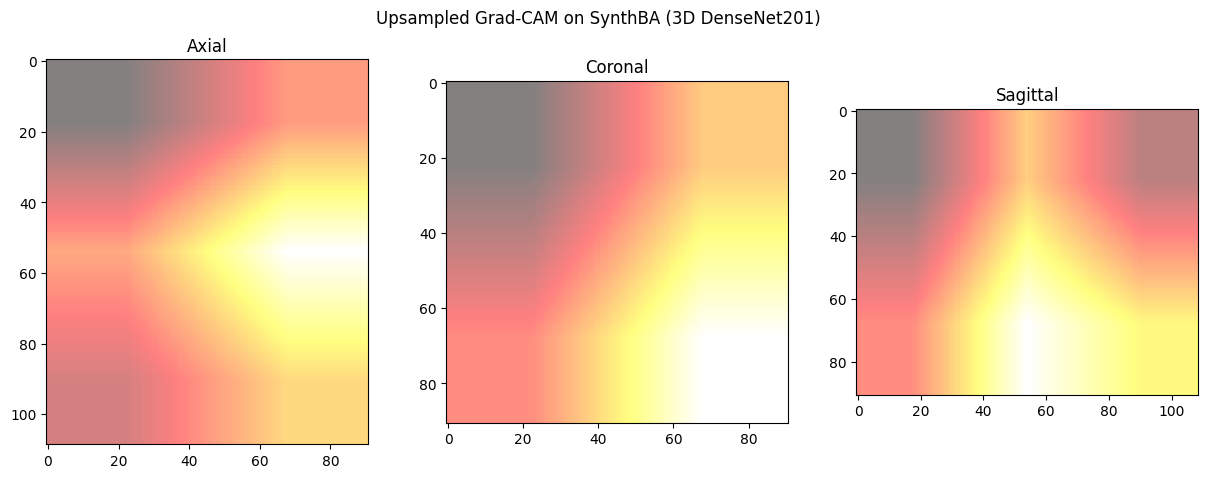

In [43]:
# only HeatMap

import matplotlib.pyplot as plt

# raw_img: already shape (D, H, W)
attr_map = upsampled_attr

# Get center slices
z, y, x = [s // 2 for s in attr_map.shape]

import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(attr_map[z], cmap='hot', alpha=0.5)
plt.title("Axial")

plt.subplot(1,3,2)
plt.imshow(attr_map[:, y, :], cmap='hot', alpha=0.5)
plt.title("Coronal")

plt.subplot(1,3,3)
plt.imshow(attr_map[:, :, x], cmap='hot', alpha=0.5)
plt.title("Sagittal")

plt.suptitle("Upsampled Grad-CAM on SynthBA (3D DenseNet201)")
plt.show()


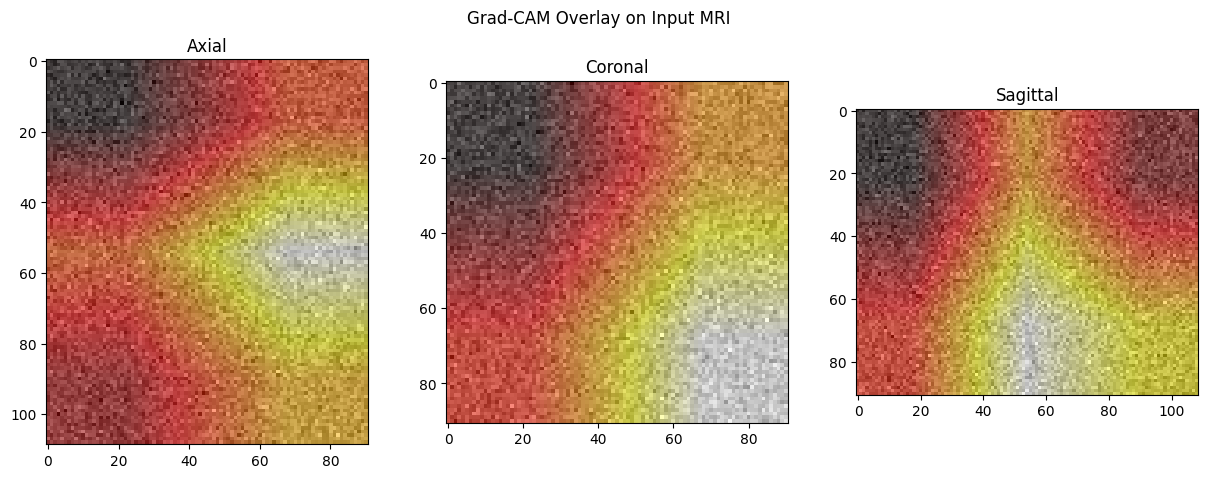

In [45]:
# overlayyed

import matplotlib.pyplot as plt

# Pick center slice for each axis
z, y, x = [s // 2 for s in img.shape]

plt.figure(figsize=(15, 5))

# Axial view
plt.subplot(1, 3, 1)
plt.imshow(img[z], cmap='gray')
plt.imshow(upsampled_attr[z], cmap='hot', alpha=0.5)
plt.title("Axial")

# Coronal view
plt.subplot(1, 3, 2)
plt.imshow(img[:, y, :], cmap='gray')
plt.imshow(upsampled_attr[:, y, :], cmap='hot', alpha=0.5)
plt.title("Coronal")

# Sagittal view
plt.subplot(1, 3, 3)
plt.imshow(img[:, :, x], cmap='gray')
plt.imshow(upsampled_attr[:, :, x], cmap='hot', alpha=0.5)
plt.title("Sagittal")

plt.suptitle("Grad-CAM Overlay on Input MRI")
plt.show()
